In [572]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt
from reservoirpy.observables import nrmse, rsquare


In [573]:
def van_der_pol(t, z, mu):
    x, y = z
    dxdt = y
    dydt = mu * (1 - x**2) * y - x
    return [dxdt, dydt]

In [574]:
mu = 1.0
initial_state = [1.0, 0.0]
t_span = (0, 500)

In [575]:
sol = solve_ivp(van_der_pol, t_span, initial_state, args=(mu,), dense_output=True)

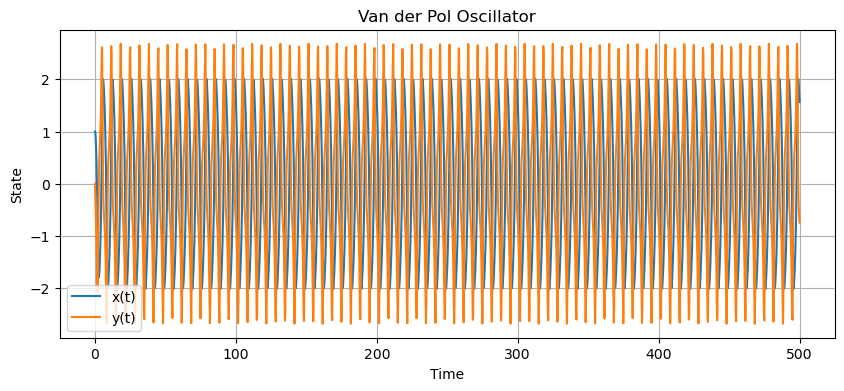

In [576]:
t = np.linspace(t_span[0], t_span[1], 2000)
z = sol.sol(t)

plt.figure(figsize=(10, 4))
plt.plot(t, z[0], label='x(t)')
plt.plot(t, z[1], label='y(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.grid()
plt.title('Van der Pol Oscillator')
plt.show()

In [577]:
t = np.linspace(t_span[0], t_span[1], 2000)
z = sol.sol(t)

data = pd.DataFrame({'Time': t, 'x': z[0], 'y': z[1]})
data.to_csv('vanderpol_dataset.csv', index=False)

In [578]:
import numpy as np

# CSVファイルを読み込む
data = np.genfromtxt('vanderpol_dataset.csv', delimiter=',', skip_header=1)

# データを操作する（例：データの表示）
print(data)


[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 2.50125063e-01  9.68834830e-01 -2.48411877e-01]
 [ 5.00250125e-01  8.76055199e-01 -4.94290136e-01]
 ...
 [ 4.99499750e+02  1.87803197e+00 -4.98232418e-01]
 [ 4.99749875e+02  1.73621906e+00 -6.29467871e-01]
 [ 5.00000000e+02  1.56427327e+00 -7.46111691e-01]]


In [579]:
print(data.shape)

(2000, 3)


In [580]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

In [581]:
X = data[:, 1]


X = (X - np.mean(X)) / np.std(X) 


In [582]:
X = X.reshape(-1, 1)
X.shape

(2000, 1)

In [583]:
def plot_train_test(X_train, y_train, X_test, y_test):
    sample = 1000
    test_len = X_test.shape[0]
    fig = plt.figure(figsize=(15, 5))
    plt.plot(np.arange(0, 1000), X_train[-sample:], label="Training data")
    plt.plot(np.arange(0, 1000), y_train[-sample:], label="Training ground truth")
    plt.plot(np.arange(1000, 1000+test_len), X_test, label="Testing data")
    plt.plot(np.arange(1000, 1000+test_len), y_test, label="Testing ground truth")
    plt.legend()
    plt.show()

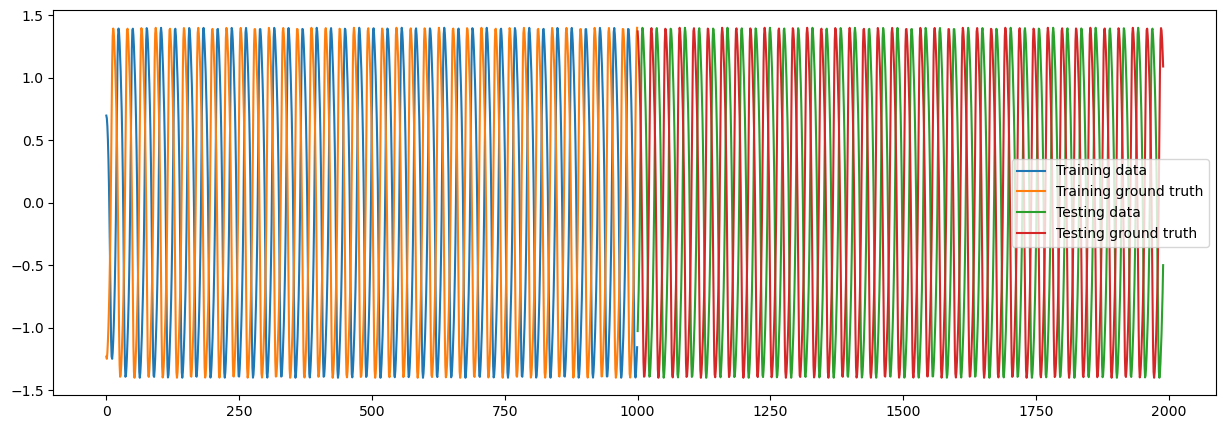

In [584]:
from reservoirpy.datasets import to_forecasting

X, Y = to_forecasting(X, forecast=10)
X_train1, Y_train1 = X[:1000], Y[:1000]
X_test1, Y_test1 = X[1000:], Y[1000:]

plot_train_test(X_train1, Y_train1, X_test1, Y_test1)

In [585]:
Y.shape

(1990, 1)

In [586]:
X_test1.shape

(990, 1)

In [587]:
units = 500
leak_rate = 0.17113764962939737
spectral_radius = 1.182082887824895
input_scaling = 0.9697295578201843
connectivity = 0.10407566959031667      # - density of reservoir internal matrix
input_connectivity = 0.2  # and of reservoir input matrix
regularization = 5.602814683095597e-09
noise_rc = 3.297333463106559e-05
seed = 1234             # for reproducibility

In [588]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                          lr=leak_rate, rc_connectivity=connectivity,
                          input_connectivity=input_connectivity, seed=seed)
    readout   = Ridge(1, ridge=regularization)

    return reservoir >> readout

In [589]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed, 
                      noise_rc=noise_rc, noise_type="normal")

readout   = Ridge(1, ridge=regularization)

esn = reservoir >> readout

In [590]:
y = esn(X[0])  # initialisation
reservoir.Win is not None, reservoir.W is not None, readout.Wout is not None

(True, True, True)

In [591]:
np.all(readout.Wout == 0.0)

True

In [592]:
esn = esn.fit(X_train1, Y_train1, warmup=100)

Running Model-19: 1000it [00:00, 13248.88it/s]         
Running Model-19: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]

Fitting node Ridge-19...


In [593]:
def plot_readout(readout):
    Wout = readout.Wout
    bias = readout.bias
    Wout = np.r_[bias, Wout]

    fig = plt.figure(figsize=(15, 5))

    ax = fig.add_subplot(111)
    ax.grid(axis="y")
    ax.set_ylabel("Coefs. of $W_{out}$")
    ax.set_xlabel("reservoir neurons index")
    ax.bar(np.arange(Wout.size), Wout.ravel()[::-1])

    plt.show()

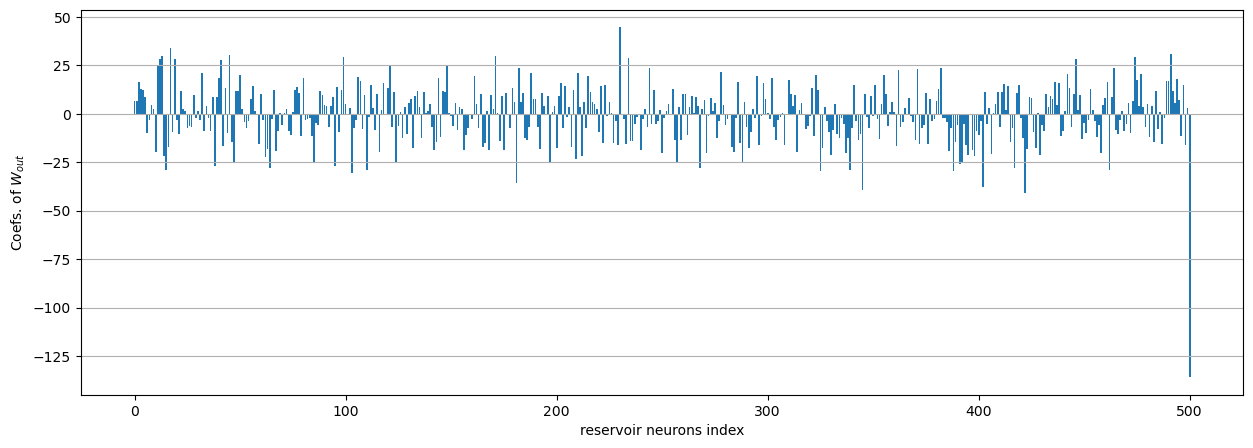

In [594]:
plot_readout(readout)

In [595]:
def plot_results(y_pred, y_test, sample=1000):

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(np.arange(sample), y_pred[:sample], lw=3, label="ESN prediction")
    plt.plot(np.arange(sample), y_test[:sample], linestyle="--", lw=2, label="True value")
    plt.plot(np.abs(y_test[:sample] - y_pred[:sample]), label="Absolute deviation")

    plt.legend()
    plt.show()

In [596]:
Y_pred1 = esn.run(X_test1)

Running Model-19: 990it [00:00, 14098.12it/s]          


In [597]:
Y_pred1.shape

(990, 1)

In [598]:
Y_test1.shape

(990, 1)

In [599]:
rsquare(Y_test1, Y_pred1), nrmse(Y_test1, Y_pred1)

(0.9992307527491049, 0.009915104497787637)

In [600]:
def plot_results(y_pred, y_test, sample=500):

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(np.arange(sample), y_pred[:sample], lw=3, label="ESN prediction")
    plt.plot(np.arange(sample), y_test[:sample], linestyle="--", lw=2, label="True value")
    plt.plot(np.abs(y_test[:sample] - y_pred[:sample]), label="Absolute deviation")

    plt.legend()
    plt.show()

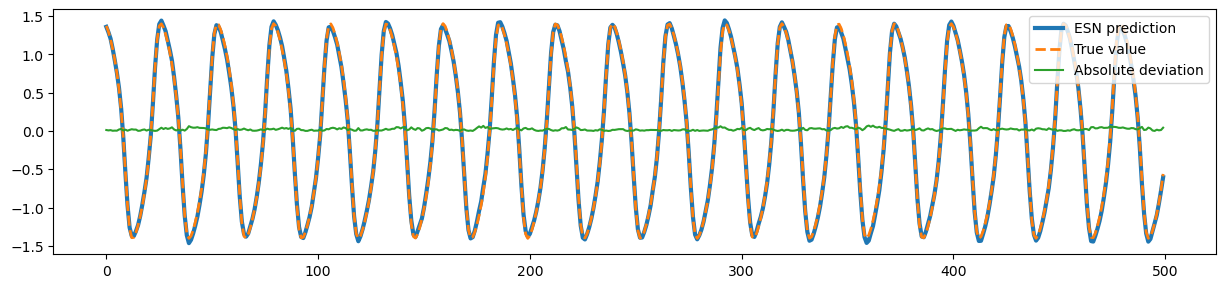

In [601]:
plot_results(Y_pred1, Y_test1)

In [602]:
rsquare(Y_test1, Y_pred1), nrmse(Y_test1, Y_pred1)

(0.9992307527491049, 0.009915104497787637)